In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tqdm.auto as tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from modular_splicing.models_for_testing.main_models import AM, FM_full
from modular_splicing.models_for_testing.spliceai_models import spliceai_400, spliceai_10k
from modular_splicing.models_for_testing.lssi_models import LSSI, LSSI_EXTRAS
from modular_splicing.dataset.alternative.merge_splice_tables import (
    splice_tables_on_common_genes,
)
from modular_splicing.models.modules.lssi_in_model import (
    BothLSSIModels,
    BothLSSIModelsJustSplicepoints,
)
from modular_splicing.other_experiments.other_human_datasets import run_model_on_all

from modular_splicing.utils.statistics import bootstrap

In [4]:
l_max = 10

In [5]:
model_specs = [
    spliceai_400,
    spliceai_10k,
    AM.non_binarized_models(),
    FM_full.non_binarized_models(),
]

colors = {
    "SpliceAI 400": "#888",
    "SpliceAI 10k": "#ccc",
    "AM": "#f44",
    "FM": "#88f",
    "LSSI": "#0c0",
}

In [6]:
splice_table_paths = {
    "can": "canonical_dataset.txt",
    "evo": "../data/evo_alt_data/evo_all.txt",
    "alt": "../data/evo_alt_data/alt_all.txt",
}

In [7]:
data_keys = ["can", "alt", "evo"]

In [8]:
canonical_data, splice_tables, _ = splice_tables_on_common_genes(
    splice_table_paths, "can"
)

In [9]:
lssi_all = [LSSI, *LSSI_EXTRAS]
lssi_models = [
    BothLSSIModelsJustSplicepoints(
        BothLSSIModels(a.path, b.path, no_linear_layers=True), cl=400
    ).cuda()
    for a, b in lssi_all
]

In [10]:
models = {ms[0].name.split("_")[0]: [m.model for m in ms] for ms in model_specs}
models = dict(LSSI_1=lssi_models, **models)

In [11]:
results = {
    m: [
        run_model_on_all(
            mod,
            canonical_data,
            splice_tables,
            ref_genome_path="/scratch/kavig/hg19.fa",
            l_max=l_max,
        )
        for mod in models[m]
    ]
    for m in tqdm.tqdm(models)
}

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
def tpr(result, L):
    pct = result["count_all"] / result["pred"].size
    thresh = np.quantile(result["pred"], 1 - L * pct)
    pred = result["pred"] >= thresh
    return {
        k: (pred & result["true"][k]).sum() / result["true"][k].sum()
        for k in result["true"]
    }


def tpr_mean(result, L):
    acc = tpr(result[1], L)
    don = tpr(result[2], L)
    assert acc.keys() == don.keys()
    return {k: (acc[k] + don[k]) / 2 for k in acc}

In [13]:
acc = {k: [tpr_mean(r, 1) for r in results[k]] for k in results}

In [14]:
def ebar(ax, x, ybot, ytop, *, color, alpha):
    ax.errorbar(
        [x],
        (ytop + ybot) / 2,
        yerr=(ytop - ybot) / 2,
        color=color,
        alpha=alpha,
        linestyle=" ",
        capsize=3,
    )

In [15]:
full_names = dict(can="(a) Canonical", alt="(b) Alternative", evo="(c) Evolutionary")

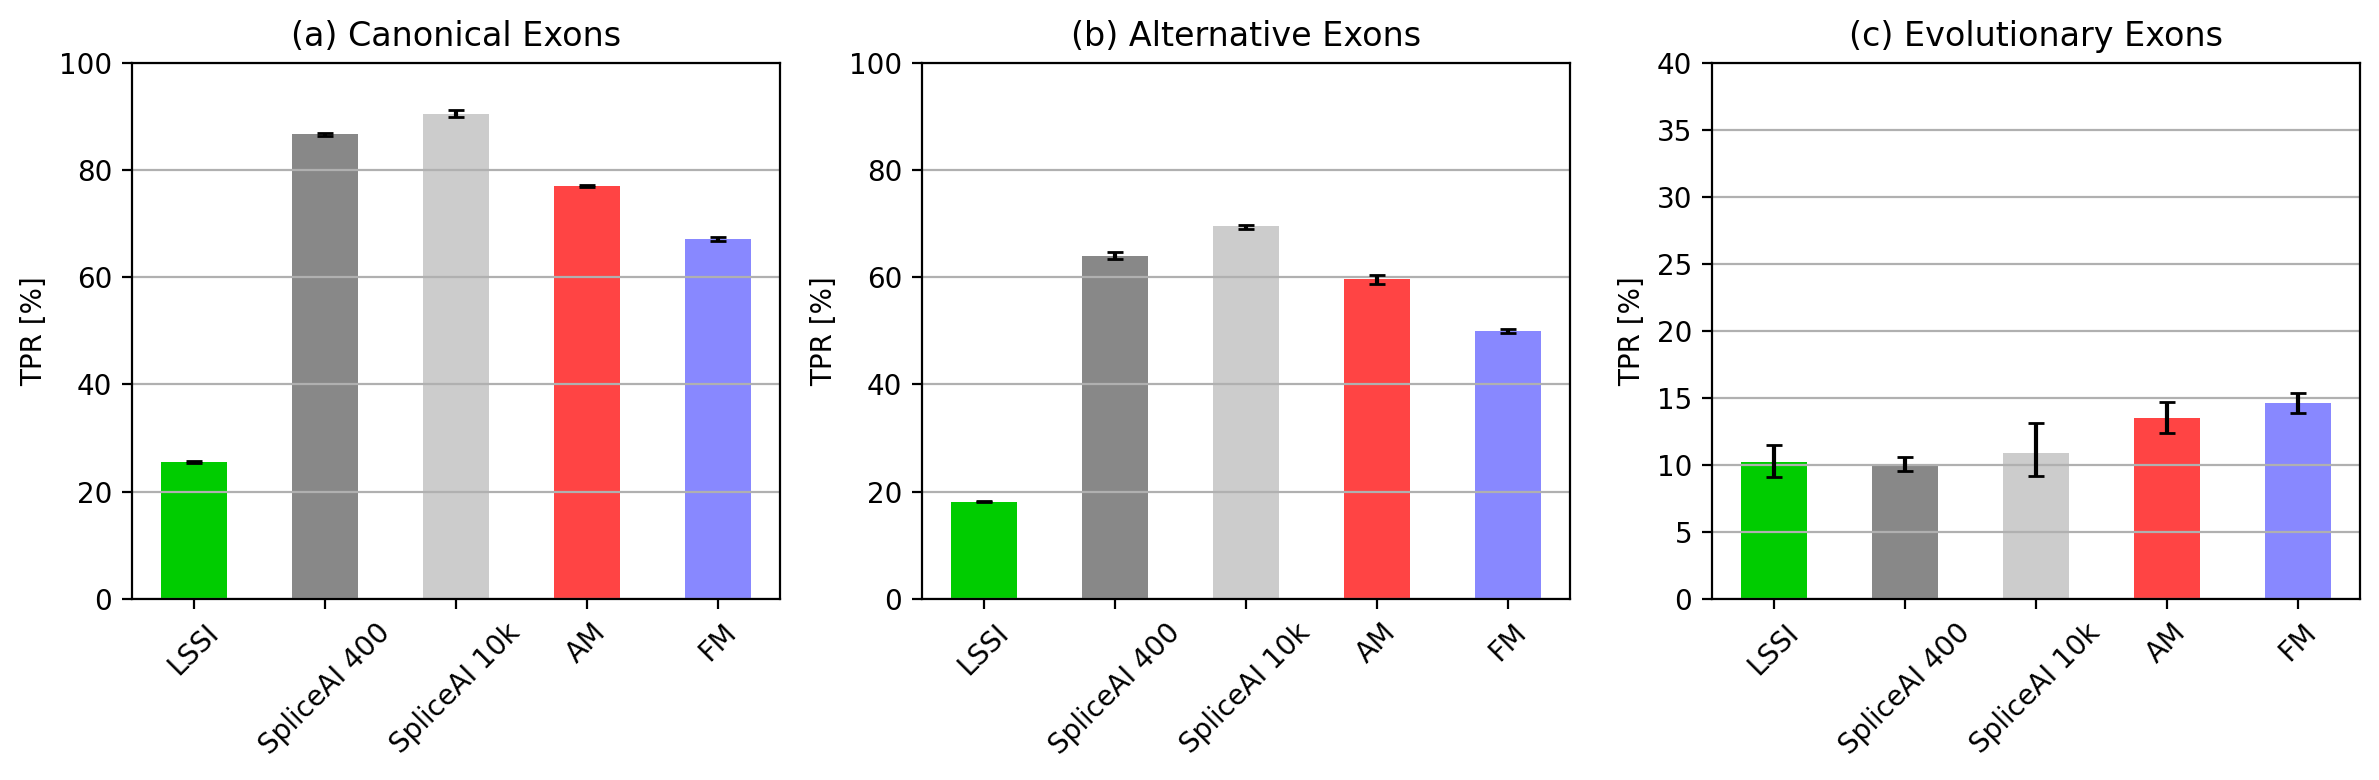

In [16]:
_, axs = plt.subplots(
    1,
    len(data_keys),
    figsize=(4 * len(data_keys), 4),
    dpi=200,
    facecolor="white",
    tight_layout=True,
)
for j, data_key in enumerate(data_keys):
    for i, model in enumerate(models):
        name = model.split("_")[0]
        values = [100 * a[data_key] for a in acc[model]]
        values = sorted(values)
        axs[j].bar([i], [np.mean(values)], width=0.5, color=colors[name])
        if len(values) > 1:
            ebar(axs[j], i, *bootstrap(values), color="black", alpha=1)

    axs[j].set_ylabel("TPR [%]")
    axs[j].set_title(full_names[data_key] + " Exons")
    axs[j].grid(axis="y")
    axs[j].set_xticks(
        np.arange(len(models)), [model.split("_")[0] for model in models], rotation=45
    )
    axs[j].set_ylim(0, 100)
axs[2].set_ylim(0, 40)
plt.savefig("../../biology-paper-1/can_alt_evo.png", facecolor="white")
plt.show()